# 필요한 라이브러리 가져오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import Request
from urllib.request import urlopen
from bs4 import BeautifulSoup
import urllib.request
import re
import time
from bs4 import BeautifulSoup as Soup
import re

# 데이터 불러오기 및 확인

In [2]:
df = pd.read_csv("/content/vgames2.csv", index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Year         16327 non-null  object
 3   Genre        16548 non-null  object
 4   Publisher    16540 non-null  object
 5   NA_Sales     16598 non-null  object
 6   EU_Sales     16598 non-null  object
 7   JP_Sales     16598 non-null  object
 8   Other_Sales  16596 non-null  object
dtypes: object(9)
memory usage: 1.3+ MB


In [4]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0,0.04


# 전처리

## Name

게임 이름에서 괄호는 지운다.

In [5]:
df.Name = df.Name.str.split('(').str[0].str.rstrip()

## Platform

Platform을 object에서 category 형식으로 바꾼다.

In [6]:
df["Platform"].astype("category").cat.categories

Index(['2007', '2010', '2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC',
       'GEN', 'GG', 'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3',
       'PS4', 'PSP', 'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU',
       'X360', 'XB', 'XOne'],
      dtype='object')

Platform의 값이 오타가 있거나 platform에 맞지 않는 데이터가 있을 수 있다.

이중에서, 먼저 오류값을 처리하기 위해 각 데이터의 수를 나타내보기로 한다.

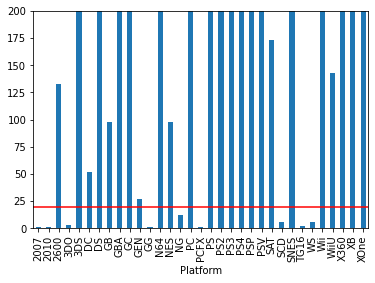

In [7]:
pd.crosstab(index = df.Platform, columns = "count").plot.bar(legend = False, ylim=(0,200))
plt.axhline(20, color = 'r')
plt.show()

대다수의 플랫폼은 200 이상의 데이터를 가지고 있다.<br>
이중 20 이상의 데이터를 가진 플랫폼명은 오류가 없는 것으로 파악하고, 20 미만의 데이터를 살펴보자.

In [8]:
df.groupby("Platform").filter(lambda x: len(x) < 20).head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1035,Formula One World Championship: Beyond the Limit,SCD,1994,Racing,Sega,0,0,0.07,0
2326,Final Fantasy,WS,2000,Role-Playing,SquareSoft,0,0,0.51,0
2353,Super Robot Taisen Compact 2 Dai-1-Bu,WS,2000,Strategy,Namco Bandai Games,0,0,0.17,0
2525,Samurai Spirits,NG,1994,Fighting,SNK,0,0,0.2,0
3320,Samurai Shodown II,NG,1994,Fighting,SNK,0,0,0.25,0


 

*   Final Fantasy를 보면 WS의 플랫폼으로 되어 있는데, 이는 WonderSwan 플랫폼을 줄인 것이다.
*   NG는 Neo Geo의 줄임으로 오류가 아니다.
*   SCD는 Sega CD의 줄임으로 오류가 아니다.
*   GG는 Game Gear의 줄임으로 오류가 아니다.
*   TG16는 TurboGrafx-16의 줄임으로 오류가 아니다.
*   3DO는 1993년 출시되었던 거치형 게임기이다.
*   PCFX는 1994년 출시되었던 거치형 게임기이다.

  따라서 위 명시된 모든 플랫폼은 오류가 아니다.





In [9]:
df.groupby("Platform").filter(lambda x: len(x) < 20).query("Platform not in ['WS','NG', '3DO', 'SCD', 'TG16', 'GG', 'PCFX']")

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7597,"B's-LOG Party??,PSP""",2010,Adventure,Idea Factory,0,0,0.04,0,NaN
16192,Boku no Natsuyasumi 3: Hokkoku Hen: Chiisana B...,2007,Adventure,Sony Computer Entertainment,0,0,0.08,0,NaN


In [10]:
print(df.Name[7597],"\n",df.Name[16192])

B's-LOG Party??,PSP" 
 Boku no Natsuyasumi 3: Hokkoku Hen: Chiisana Boku no Dai Sougen??,PS3"


남은 두 데이터는 모두 "??,"으로 Platform과 Name이 합쳐져 한칸씩 밀린 것을 알 수 있다.

따라서 수정해 줄 필요가 있다.

In [11]:
df.iloc[[7596, 16191]] = df.T[[7597, 16192]].shift(1, axis=0).T

In [12]:
[df.Name[7597], df.Platform[7597]] = df.Platform[7597].split('??,')
[df.Name[16192], df.Platform[16192]] = df.Platform[16192].split('??,')
df.Platform[7597] = df.Platform[7597].rstrip('"')
df.Platform[16192] = df.Platform[16192].rstrip('"')

In [13]:
df.iloc[[7596, 16191]]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7597,B's-LOG Party,PSP,2010,Adventure,Idea Factory,0,0,0.04,0
16192,Boku no Natsuyasumi 3: Hokkoku Hen: Chiisana B...,PS3,2007,Adventure,Sony Computer Entertainment,0,0,0.08,0


## Year

### 정수 형태로 변환

Year column의 type를 정수 형태로 바꿀 필요가 있다.

1. Year 열에 271개의 null 값이 있으므로, 정보를 검색해 찾아준다.

(추가) 사실 원래 주어진 데이터 Year에 정확하지 않은 정보가 많음을 알아내었다.<br>
따라서 값을 지우고 다시 채우는 것이 좋을 것 같다.<br>
하지만 데이터가 너무 많아 실행 시간이 너무 오래 걸리므로, 생략한다.
네자리 수거나 9로 시작하는 두자리 값은 앞에 19를 채워준다.
나머지와 null은 0으로 바꾼다.


In [14]:
df.Year = df.Year.astype(float).astype("Int32")

In [15]:
def year_check(year):
  if pd.isna(year):
    return 0
  if year < 2030 and 1900 < year:
    return year
  elif year<100 and 90<year:
    return 1900+year
  else:
    return 2000+year

In [16]:
df['Year'] = df['Year'].apply(lambda x:year_check(x))

### 결측치 채우기

\* null값이 많으므로 게임 이름을 입력하면 위키피디아, 메타크리틱, 구글에서 게임연도를 찾아 반환하는 함수를 만들었다.

#### Metacritic에서 가져오기

In [17]:
urlplatform = {'2600':'2600', '3DS':'3ds', 'DS':'ds', 'GBA':'game-boy-advance', 'GC':'gamecube', 'N64':'nintendo-64', 'PC':'pc', 
               'PS':'playstation', 'PS2':'playstation-2', 'PS3':'playstation-3', 'PSP':'psp', 'Wii':'wii', 'X360':'xbox-360', 'XB':'xbox'}


def find_game_years_meta(game_name, platform):
  try:
    game_name = game_name.lower().replace(' ','-').replace(':','-').replace('--','-').replace('--','-').replace("'",'')
    platform = urlplatform[platform]
    url = "https://www.metacritic.com/game/"+platform+"/"+game_name
    req = Request(url,headers={'User-Agent':'Mozila/5.0'})
    webpage = urlopen(req)
    soup = BeautifulSoup(webpage)
    yeardata = soup.find('div', { 'class' : "product_data"})
    temp = re.split(r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Apr|Sep|Oct|Nov|Dec)\s{1}",str(yeardata))[-1]
    r1 = re.findall(r"\d{4}",temp)
    return int(min(r1))
  except:
    return np.NAN

In [18]:
df.Year = df.apply(lambda row: row.Year if (row.Year < 2030 and row.Year > 1900) else find_game_years_meta(row.Name, row.Platform), axis=1)

#### Wikipedia에서 가져오기

In [19]:
def find_game_years(game_name):
  try:
    url = "https://en.wikipedia.org/wiki/"+game_name
    url = url.replace(' ','_')
    req = Request(url,headers={'User-Agent':'Mozila/5.0'})
    
    webpage = urlopen(req)
    
    soup = BeautifulSoup(webpage)

    htmltable = soup.find('table', { 'class' : "infobox ib-video-game hproduct"})
    from itertools import product
    def table_to_2d(table_tag):
        rowspans = []
        rows = table_tag.find_all('tr')

        colcount = 0
        for r, row in enumerate(rows):
            cells = row.find_all(['td', 'th'], recursive=False)
            colcount = max(
                colcount,
                sum(int(c.get('colspan', 1)) or 1 for c in cells[:-1]) + len(cells[-1:]) + len(rowspans))
            rowspans += [int(c.get('rowspan', 1)) or len(rows) - r for c in cells]
            rowspans = [s - 1 for s in rowspans if s > 1]

        table = [[None] * colcount for row in rows]

        rowspans = {}
        for row, row_elem in enumerate(rows):
            span_offset = 0
            for col, cell in enumerate(row_elem.find_all(['td', 'th'], recursive=False)):
                col += span_offset
                while rowspans.get(col, 0):
                    span_offset += 1
                    col += 1
                    
                rowspan = rowspans[col] = int(cell.get('rowspan', 1)) or len(rows) - row
                colspan = int(cell.get('colspan', 1)) or colcount - col
                span_offset += colspan - 1
                value = cell.get_text()
                for drow, dcol in product(range(rowspan), range(colspan)):
                    try:
                        table[row + drow][col + dcol] = value
                        rowspans[col + dcol] = rowspan
                    except IndexError:
                        pass
                        
            rowspans = {c: s - 1 for c, s in rowspans.items() if s > 1}

        return table

    temp_table = pd.DataFrame(table_to_2d(htmltable)).set_index(0)
    temp = temp_table.loc['Release'][1]
    
    r1 = re.findall(r"\d{4}",temp)
    return int(min(r1))
  except:
    return np.NAN

In [20]:
df.Year = df.apply(lambda row: row.Year if (row.Year < 2030 and row.Year > 1900) else find_game_years(row.Name), axis=1)

#### 구글 헤드에서 가져오기

In [21]:
def find_game_years_google(game_name, platform):
  try:
    game_name = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", game_name)
    game_name = game_name.replace("\t", "")
    url = "https://www.google.com/search?q="+game_name+" "+platform+" game year&aqs=chrome..69i57.4560j0j9&sourceid=chrome&ie=UTF-8"
    url = url.replace(' ','%20')
    req = Request(url, headers = {'User-Agent':'Chrome/66.0.3359.181'})
    webpage = urlopen(req)
    soup = BeautifulSoup(webpage)
    temp = re.split(r"(January|February|March|April|May|June|July|August|September|October|November|December)\s{1}",str(soup))[4]
    temp = re.split("</span></span>",temp)[0]
    r1 = re.findall(r"\d{4}",temp)
    return int(min(r1))
  except:
    return np.NAN

In [22]:
df.Year = df.apply(lambda row: row.Year if (row.Year <= 2020 and row.Year > 1900) else find_game_years_google(row.Name, row.Platform), axis=1)

In [23]:
def find_game_years_google2(game_name, platform):
  try:
    game_name = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", game_name)
    game_name = game_name.replace("\t", "")

    url = "https://www.google.com/search?q="+game_name+" "+platform+" game release date"
    url = url.replace(' ','%20')
    req = Request(url, headers = {'User-Agent':'Chrome/66.0.3359.181'})
    webpage = urlopen(req)
    soup = BeautifulSoup(webpage)
    r1 = re.findall(r"\d{4}",str(soup))
    r1 = [i for i in r1 if int(i)<2020 and int(i)>1900]
    return int(max(r1, key=r1.count))
  except:
    return np.NAN

In [24]:
df.Year = df.apply(lambda row:row.Year if (row.Year <= 2018 and row.Year > 1900) else find_game_years_google2(row.Name, row.Platform), axis=1).astype("Int32")

## Genre

### Metacritic에서 가져오기

Genre 값에 50개의 null값이 있다. 메타크리틱에서 크롤링해오자.

In [25]:
def find_game_genres_meta(game_name, platform):
  try:
    game_name = game_name.lower().replace(' ','-').replace(':','-').replace('--','-').replace('--','-').replace("'",'')
    platform = urlplatform[platform]
    url = "https://www.metacritic.com/game/"+platform+"/"+game_name
    req = Request(url,headers={'User-Agent':'Mozila/5.0'})
    webpage = urlopen(req)
    soup = BeautifulSoup(webpage)
    genredata = soup.find('li', { 'class' : "summary_detail product_genre"})
    return str(genredata).split('<span class="data">')[1].split('</span>')[0]
  except:
    return np.NAN

In [26]:
df.Genre = df.apply(lambda row: find_game_genres_meta(row.Name, row.Platform) if pd.isna(row.Genre) else row.Genre, axis=1)

### 수동으로 채우기

In [27]:
df[df.Genre.isna()] #수동으로 찾아야 하는 목록

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1583,SingStar Singalong With Disney,PS2,2008,NaN,Sony Computer Entertainment,0,0.04,0,0.57
1972,Pokemon X/Pokemon Y,3DS,2013,NaN,Nintendo,5170K,4.05,4.34,0.79
2044,NASCAR Racing,PS,1996,NaN,Pioneer LDC,0.23,0.16,0,0.03
3354,The Godfather: Dons Edition,PS3,2007,NaN,Electronic Arts,0.25,0.02,0,0.03
3516,Princess Saver! Eternal Love for My Lady,PS2,2010,NaN,Comfort,0,0,0.02,0
4149,Grand Theft Auto IV,PC,2008,NaN,Take-Two Interactive,0.01,0.79,0,0.08
4350,Brain Quest: Grades 5 & 6,DS,2008,NaN,Electronic Arts,0.11,0,0,0.01
5714,Back to the Future: The Game,XOne,2015,NaN,Telltale Games,0,0.02,0,0
5946,Medabots: Metabee,GBA,2002,NaN,Natsume,0.04,0.01,0,0
6799,UFO: Trilogy,PC,2007,NaN,Unknown,0,0.02,0,0


In [28]:
# df.Genre[df[df.Genre.isna()].index.tolist()] = ["Action", "Role-Playing", "Driving", "Action Adventure", "Adventure", "Puzzle", 
#                                                 "Adventure", "Action", "Role-Playing", "Action", "Action Adventure", "Adventure", 
#                                                 "Adventure", "Action", "Strategy", "Action", "Puzzle", "Puzzle", "Role-Playing"]

In [29]:
df.Genre[df[df.Genre.isna()].index.tolist()] = ["Simulation", "Platform", "Racing", "Misc", "Platform", "Action Adventure", "Action", "Role-Playing", "Puzzle", "Adventure", "Racing", "Misc", "Misc", "Misc", "Sports", "Adventure", "Sports", "Misc", "Misc", "Fighting", "Fighting", "Misc", "Fighting", "Action", "Puzzle", "Simulation"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df.Genre = df.Genre.replace('Miscellaneous','Misc')

## Publisher

### Metacritic에서 가져오기

In [31]:
def find_game_Publisher_meta(game_name, platform):
  try:
    game_name = game_name.lower().replace(' ','-').replace(':','-').replace('--','-').replace('--','-').replace("'",'')
    platform = urlplatform[platform]
    url = "https://www.metacritic.com/game/"+platform+"/"+game_name
    req = Request(url,headers={'User-Agent':'Mozila/5.0'})
    webpage = urlopen(req)
    soup = BeautifulSoup(webpage)
    publisher = soup.find('li', { 'class' : "summary_detail publisher"})
    return str(publisher).split('<span class="data">')[1].split('</span>')[0]
  except:
    return np.NAN

In [32]:
df.Publisher = df.apply(lambda row: find_game_Publisher_meta(row.Name, row.Platform) if pd.isna(row.Publisher) else row.Publisher, axis=1)

### Wikipedia에서 가져오기

In [33]:
def find_game_publisher(game_name):
  try:
    url = "https://en.wikipedia.org/wiki/"+game_name
    url = url.replace(' ','_')
    req = Request(url,headers={'User-Agent':'Mozila/5.0'})
    
    webpage = urlopen(req)
    
    soup = BeautifulSoup(webpage)

    htmltable = soup.find('table', { 'class' : "infobox ib-video-game hproduct"})
    from itertools import product
    def table_to_2d(table_tag):
        rowspans = []
        rows = table_tag.find_all('tr')

        colcount = 0
        for r, row in enumerate(rows):
            cells = row.find_all(['td', 'th'], recursive=False)
            colcount = max(
                colcount,
                sum(int(c.get('colspan', 1)) or 1 for c in cells[:-1]) + len(cells[-1:]) + len(rowspans))
            rowspans += [int(c.get('rowspan', 1)) or len(rows) - r for c in cells]
            rowspans = [s - 1 for s in rowspans if s > 1]

        table = [[None] * colcount for row in rows]

        rowspans = {}
        for row, row_elem in enumerate(rows):
            span_offset = 0
            for col, cell in enumerate(row_elem.find_all(['td', 'th'], recursive=False)):
                col += span_offset
                while rowspans.get(col, 0):
                    span_offset += 1
                    col += 1
                    
                rowspan = rowspans[col] = int(cell.get('rowspan', 1)) or len(rows) - row
                colspan = int(cell.get('colspan', 1)) or colcount - col
                span_offset += colspan - 1
                value = cell.get_text()
                for drow, dcol in product(range(rowspan), range(colspan)):
                    try:
                        table[row + drow][col + dcol] = value
                        rowspans[col + dcol] = rowspan
                    except IndexError:
                        pass
                        
            rowspans = {c: s - 1 for c, s in rowspans.items() if s > 1}

        return table

    temp_table = pd.DataFrame(table_to_2d(htmltable)).set_index(0)
    temp = temp_table.loc['Publisher(s)'][1]
    return temp
  except:
    return np.NAN

In [34]:
df.Publisher = df.apply(lambda row: find_game_publisher(row.Name) if pd.isna(row.Publisher) else row.Publisher, axis=1)

### 나머지 결측치

나머지 Publisher는 Unknown으로 취급한다.

In [35]:
df['Publisher'] =  df['Publisher'].fillna('Unknown')

## Sales

판매량의 데이터를 float으로 바꾼다.<br>
룬팩3, 룬팩 프론티어의 실제 일본 판매량이 각각 10만장, 4만장이고 표시된 숫자는 0.1, 0.04임을 고려하면, 배율은 약 100만으로 생각하면 된다.<br>
전처리를 방해하는 뒤의 K(Kilounits)와 M(Megaunits)은 각각 1000, 100만이므로,<br>
K는 0.001을 곱해주고, M은 그냥 제거하면 된다.

### K와 M을 지우기

In [36]:
Sales_cols = df.columns[df.columns.str.endswith('_Sales')]
for col in Sales_cols:
  t1 = df[col].str.endswith('K', na=False)
  if t1.sum():
    temp = df[t1].index
    for i in temp:
      t = df[col][i]
      df[col][i] = float(t[:-1])*0.001

for col in Sales_cols:
  t1 = df[col].str.endswith('M', na=False)
  if t1.sum():
    temp = df[t1].index
    for i in temp:
      t = df[col][i]
      df[col][i] = float(t[:-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### 데이터 타입을 float로 바꾸기

In [37]:
df[Sales_cols] = df[Sales_cols].astype(float)

In [38]:
df = df.sort_values(by=['Year', 'Name'])
df = df.reset_index(drop = True)
df.to_csv('vgames_mod.csv',index=False) #melt를 적용하지 않은 df

### Melt로 처리 후 결측치 제거

In [39]:
Sales_cols = df.columns[df.columns.str.endswith('_Sales')]
ids = [item for item in df.columns if item not in Sales_cols]
df = pd.melt(df, id_vars=ids, value_vars=Sales_cols, var_name = 'State', value_name = 'Sales')
df.State = df.State.str.replace('_Sales','')

## 마무리 확인 & 전처리 데이터 내보내기

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66392 entries, 0 to 66391
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       66392 non-null  object 
 1   Platform   66392 non-null  object 
 2   Year       66392 non-null  Int32  
 3   Genre      66392 non-null  object 
 4   Publisher  66392 non-null  object 
 5   State      66392 non-null  object 
 6   Sales      66392 non-null  float64
dtypes: Int32(1), float64(1), object(5)
memory usage: 3.4+ MB


In [41]:
df.isnull().sum()

Name         0
Platform     0
Year         0
Genre        0
Publisher    0
State        0
Sales        0
dtype: int64

In [42]:
df = df.sort_values(by=['Year', 'Name'])
df = df.reset_index(drop = True)

결측치를 모두 처리하였으며, 데이터 타입도 모두 바꾸었다.<br>
마지막으로 연도와 이름 순으로 정렬 후 index를 리셋하는 것으로 전처리를 마무리한다.

In [43]:
df.to_csv('vgames_mod2.csv',index=False) #melt를 적용한 df

# 데이터 활용

In [44]:
df = pd.read_csv("/content/vgames_mod2.csv")
df.State = df.State.replace(np.NaN,'NA')

In [45]:
display(df.head())

,Name,Platform,Year,Genre,Publisher,State,Sales
0,Adventure,2600,1976,Adventure,Atari,NA,1.21
1,Adventure,2600,1976,Adventure,Atari,EU,0.08
2,Adventure,2600,1976,Adventure,Atari,JP,0.00
3,Adventure,2600,1976,Adventure,Atari,Other,0.01
4,Air-Sea Battle,2600,1977,Shooter,Atari,NA,0.91


## Mission 1 : 지역에 따라서 선호하는 게임 장르가 다를까?



*   Solution 1_1: Anova 분석를 이용한 답 도출 
 




In [46]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [47]:
out = ols('Sales ~ State*Genre', data=df).fit()
print("ANOVA")
display(sm.stats.anova_lm(out, typ=2))

ANOVA


,sum_sq,df,F,PR(>F)
State,461.082116,3.0,592.099774,0.000000e+00
Genre,121.715483,13.0,36.069519,1.278720e-91
State:Genre,145.369382,39.0,14.359728,4.965824e-93
Residual,17219.138048,66336.0,NaN,NaN


지역(State)과 장르(Genre) 상호작용(State:Genre)에 대한 p-value = 1.247609e-92<0.05이므로,<br> 
유의수준 5% 하에서 지역과 장르에 따라 매출량이 다르다.
따라서 지역에 따라서 선호하는 게임 장르가 다르다.

In [48]:
import seaborn as sns

*   Solution 1_2: sns.barplot을 통한 시각화 프로세스

In [49]:
df_NA = df[df.State == 'NA']
df_EU = df[df.State == 'EU']
df_JP = df[df.State == 'JP']
df_Other = df[df.State == 'Other']

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


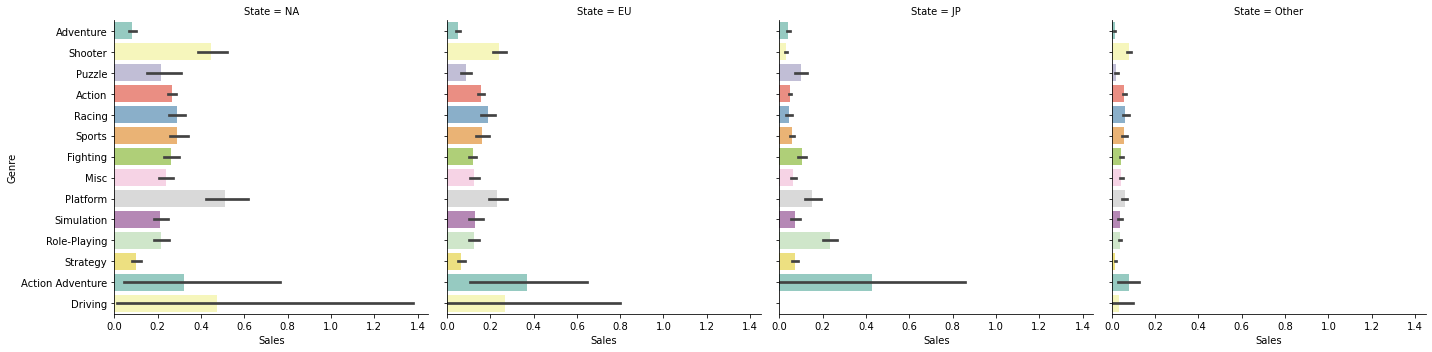

In [50]:
g = sns.FacetGrid(df, col = 'State', height=5)
g.map(sns.barplot, "Sales", "Genre", palette="Set3");

* *Miscellaneous (Misc.) = 기타 분류를 의미*

boxplot을 그려보면, 지역에 따라서 선호하는 게임 장르가 다르다는 것을 확인할 수 있다.<br>
특히, 북미, 유럽쪽은 Shooter, Platform가 우세인데 비해 <br>
일본 지역은 RPG와 Action Adventure가 우세이다. <br>

## Mission 2 : 연도별 게임의 트렌드가 있을까?

* 데이터의 평균과 합 중 어느것이 분석에 더 알맞을지 고민하다가 데이터에 포함된 게임수에 따라 어느 정도 보정이 있는 합보다는 평균이 더 알맞을 것 같아 평균을 기준으로 작성하였습니다.
* 또한 도출해내고자 하는 값이 '다음 분기에 어떤 게임을 발매할까'이기에 평균을 고려하였습니다.
* 처음에는 그래프를 선그래프로 할까 하다가 범례가 너무 많아지고 그만큼 읽기 힘든 그래프였습니다. 따라서 histplot을 약간 변형한 그래프를 만들었습니다.

### 연도별 플랫폼의 변화

1970s          1980s          1990s          2000s          2010s      
  Platform Sales Platform Sales Platform Sales Platform Sales Platform Sales
0     2600  0.22     SNES  1.63       GB  0.59       GB  0.23      PS4  0.21
1                      GB  1.27       PC  0.30      PS3  0.20     X360  0.19
2                     NES  0.73      GEN  0.25     X360  0.20     XOne  0.17

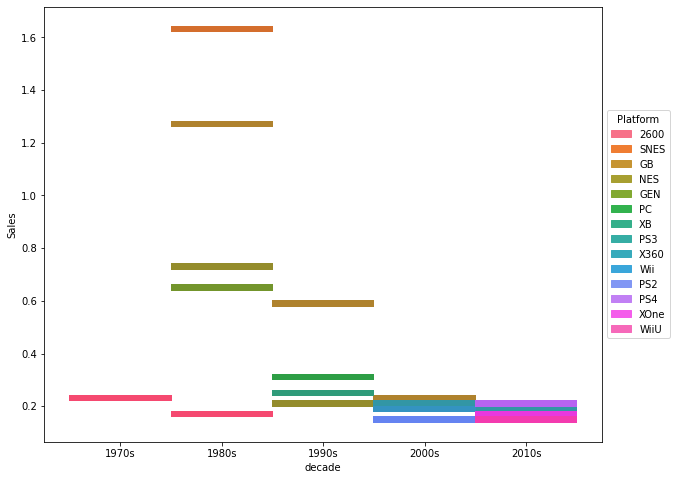

In [71]:
dcd_list = []
dcd = range(197, 202)
for i in dcd:
  temp = pd.DataFrame(df[(df.Year<=(i+1)*10) & (df.Year>(i)*10)].groupby(df.Platform).Sales.mean().round(2).sort_values(ascending=False)[:3]).reset_index()
  temp.columns=pd.MultiIndex.from_product([[str((i)*10)+'s'],temp.columns])
  dcd_list.append(temp)
dcd_list = pd.concat(dcd_list, axis=1)
dcd_list = dcd_list.replace(np.NaN, '')

dcd2_list = []
dcd = range(197, 202)
for i in dcd:
  temp = pd.DataFrame(df[(df.Year<=(i+1)*10) & (df.Year>(i)*10)].groupby(df.Platform).Sales.mean().round(2).sort_values(ascending=False)).reset_index().head(5)
  dcd2_list.append(temp)
dcd_list2 = pd.concat(dcd2_list, axis=0 , keys=dcd).reset_index()
dcd_list2 = dcd_list2.rename(columns = {'level_0':'decade'}).drop('level_1', axis=1)

dcd_list2.decade = (dcd_list2.decade*10).astype(str) + 's'
plt.figure(figsize=(10,8))
g=sns.histplot(dcd_list2, x="decade", hue="Platform", y="Sales", binwidth=0.02)
sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5))
display(dcd_list.head(3))
plt.show()

비디오 게임의 초기인 1970년대에는 아타리 2600이 독점하던 상황이었다.<br>
1980년대에는 아타리 쇼크에 일본 게임이 주가 되면서 슈퍼 패미컴이 석권하는 시대로, 평균 약 1.6M의 판매량이 있었다.<br>
1990년대에는 그 전 년대에 2위였던 게임보이가 1위로 올라섰으나, 평균적인 게임 판매량은 반 이상 줄었던 것으로 보인다.<br>
2000년대에는 플레이스테이션이 인기를 얻어가는 것으로 보이며,<br> 이전 플레이스테이션 기종(PS, PS2 등)이 순위권 외였던 것을 고려하면, PS3 게임의 시장에서의 인지도는 상당히 높아졌다고 볼 수 있다.
2010년대에는 PS4가 1위로 올라섰고, X360과 XOne이 뒤를 이었다.
이러한 추세로 볼 때, 다음 년대에는 X360의 후속 세대 기기인 XOne과 PS4의 후속 세대 기기인 PS5의 시장성을 기대해 볼만 하다고 고려된다.


### 연도별 장르의 변화

1970s            1980s               1990s                   2000s  \
       Genre Sales      Genre Sales         Genre Sales             Genre   
0    Shooter  0.66   Platform   1.0      Platform  0.34  Action Adventure   
1  Adventure  0.32     Puzzle  0.82  Role-Playing  0.26           Driving   
2   Fighting  0.19  Adventure   0.6        Action   0.2          Platform   

            2010s        
  Sales     Genre Sales  
0  0.30   Shooter   0.3  
1  0.19  Platform  0.21  
2  0.17    Sports  0.15

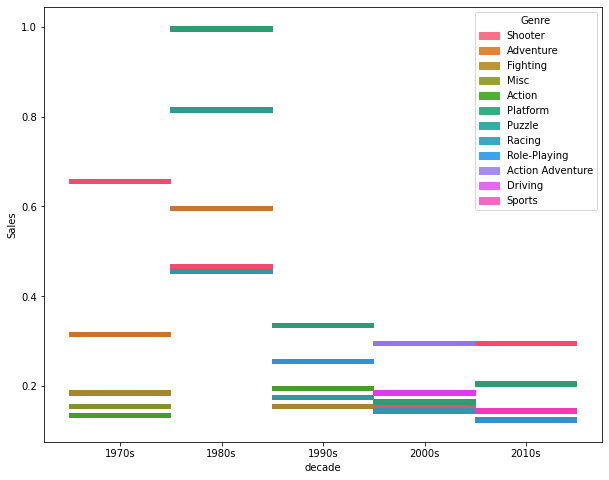

In [75]:
dcd_list = []
dcd = range(197, 202)
for i in dcd:
  temp = pd.DataFrame(df[(df.Year<=(i+1)*10) & (df.Year>(i)*10)].groupby(df.Genre).Sales.mean().round(2).sort_values(ascending=False)).reset_index()
  temp.columns=pd.MultiIndex.from_product([[str((i)*10)+'s'],temp.columns])
  dcd_list.append(temp)
dcd_list = pd.concat(dcd_list, axis=1)
dcd_list = dcd_list.replace(np.NaN, '')
display(dcd_list.head(3))

dcd2_list = []
dcd = range(197, 202)
for i in dcd:
  temp = pd.DataFrame(df[(df.Year<=(i+1)*10) & (df.Year>(i)*10)].groupby(df.Genre).Sales.mean().round(2).sort_values(ascending=False)).reset_index().head(5)
  dcd2_list.append(temp)
dcd_list2 = pd.concat(dcd2_list, axis=0 , keys=dcd).reset_index()
dcd_list2 = dcd_list2.rename(columns = {'level_0':'decade'}).drop('level_1', axis=1)

dcd_list2.decade = (dcd_list2.decade*10).astype(str) + 's'
plt.figure(figsize=(10,8))
sns.histplot(dcd_list2, x="decade", hue="Genre", y="Sales", binwidth=0.01)

plt.show()

1970년대에는 슈팅 게임이 앞섰다. 슈팅게임은 비교적 간단한 게임 구조와 조작성 덕분에 비디오 게임계 역사의 초기부터 존재하였는데, 이 시대에는 비디오게임의 대부분이 슈팅 게임이었다고 한다.<br>
1980년대에는 슈퍼마리오 등의 플랫폼 게임이 발전하면서 플랫폼 게임의 시대가 열린 것으로 보인다. 판매량은 기존 슈팅게임의 두 배 가량 올랐다.<br>
1990년대에는 발매량이 크게 줄었다. 연도별 다른 그래프를 보아도 1980년대는 발매량이 높다가 1990년대부터는 발매량이 크게 줄었는데, 이는 1980년대 일본의 거품경제때문에 일시적으로 1980년대의 발매량이 높았던 것으로 보인다.  <br>
2000년대에는 액션 어드벤처 게임이라는 액션과 어드벤처 장르를 결합한 새로운 장르의 게임이 주가 되었다. 갈수록 단조로워지던 액션 게임과 그래픽이 떨어지던 어드벤처 게임의 단점을 극복하고 융합하여 가장 대중적이고 직감적인 조작성과 함께 스토리텔링 요소를 갖춘 액션 어드벤처 게임이 인기를 얻을 수 있었던 이유이다. <br>
2010년대에는 다시 슈팅 게임의 판매량이 올랐는데, 이는 슈팅 게임이 3차원 환경을 갖추면서 1인칭 슈팅 게임인 FPS가 대중화되면서 생긴 결과이다.

### 연도별 배급사의 변화

1970s                   1980s                      1990s        \
    Publisher Sales         Publisher Sales            Publisher Sales   
0       Atari  0.27          Nintendo  1.25              Red Orb  0.66   
1  Activision  0.14            Palcom  1.04             Nintendo  0.64   
2       Sears  0.05  Enix Corporation   0.8  Arena Entertainment  0.59   

                                2000s                         2010s        
                            Publisher Sales               Publisher Sales  
0                            Nintendo  0.62                   Valve  0.43  
1  Sony Computer Entertainment Europe  0.61                Nintendo  0.42  
2                           RedOctane  0.54  Microsoft Game Studios  0.42

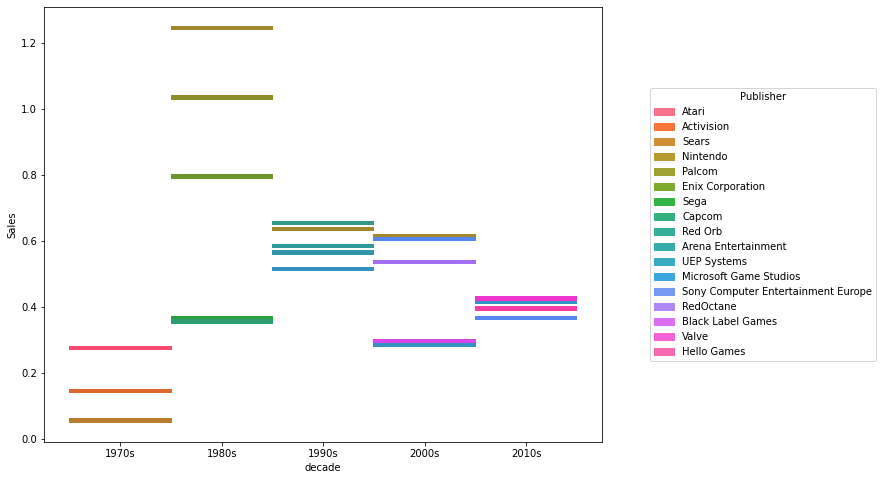

In [81]:
dcd_list = []
dcd = range(197, 202)
for i in dcd:
  temp = pd.DataFrame(df[(df.Year<=(i+1)*10) & (df.Year>(i)*10)].groupby(df.Publisher).Sales.mean().round(2).sort_values(ascending=False)).reset_index()
  temp.columns=pd.MultiIndex.from_product([[str((i)*10)+'s'],temp.columns])
  dcd_list.append(temp)
dcd_list = pd.concat(dcd_list, axis=1)
dcd_list = dcd_list.replace(np.NaN, '')
display(dcd_list.head(3))

dcd2_list = []
dcd = range(197, 202)
for i in dcd:
  temp = pd.DataFrame(df[(df.Year<=(i+1)*10) & (df.Year>(i)*10)].groupby(df.Publisher).Sales.mean().round(2).sort_values(ascending=False)).reset_index().head(5)
  dcd2_list.append(temp)
dcd_list2 = pd.concat(dcd2_list, axis=0 , keys=dcd).reset_index()
dcd_list2 = dcd_list2.rename(columns = {'level_0':'decade'}).drop('level_1', axis=1)

dcd_list2.decade = (dcd_list2.decade*10).astype(str) + 's'
plt.figure(figsize=(10,8))
g = sns.histplot(dcd_list2, x="decade", hue="Publisher", y="Sales", binwidth=0.01, legend=True)
sns.move_legend(g, "center right", bbox_to_anchor=(1.5, 0.5))

plt.show()

1970년대에는 비디오게임이라는 분야를 개척한 기업인 아타리가 게임 산업을 장악했다.<br>
하지만 아타리의 독과점으로 무너진 아타리 게임의 품질과 여러 라이벌 기업의 등장으로 아타리 쇼크가 발생하여 1980년대 완전히 몰락하게 되었다.<br>
1980년대에는 닌텐도와 팔콤, 에닉스(스퀘어에닉스의 전신)등의 일본 게임기업이 주류가 되었다. 특히 일본 거품 경제와 맞물려 매출량도 상당했던 것으로 보인다. <br>
1990년대에는 평균으로 볼 때는 레드오브 엔터테인먼트가 1위인데, 레드오브는 브로드오브 회사가 비디오게임 타이틀을 마케팅하기 위해 만든 퍼블리싱 부서로, 브로드오브로 더 잘 알려져 있다. 1993년 미스트를 발매하면서 멀티미디어 컴퓨팅의 태동기인 1990년대에 게임업계를 뒤흔든 대히트작을 만들어냈기 때문에 평균이 높게 표시된 것으로 보인다. <br>
미스트는 수작으로 뽑혔지만 그후 수많은 아류작이 등장하면서 인기가 떨어지게 되어,
2000년대에는 다시 닌텐도가 1위로 올라섰다.<br>
2010년대에는 치밀한 구성과 높은 완성도, 독창적인 게임성을 높게 평가받는 밸브사의 게임이 평균 발매량이 높았다. 게임 개발에 오랜 시간을 들여 출시작은 많지 않지만, 하나 하나가 완성도가 높아 인기가 많다고 한다. 평균 발매량이 거의 비슷한 닌텐도가 2위인데, 닌텐도의 게임 수가 압도적으로 많은 것을 생각하면, 합계는 닌텐도가 가장 많은 것을 알 수 있다.

# 다음 분기에 설계할 게임

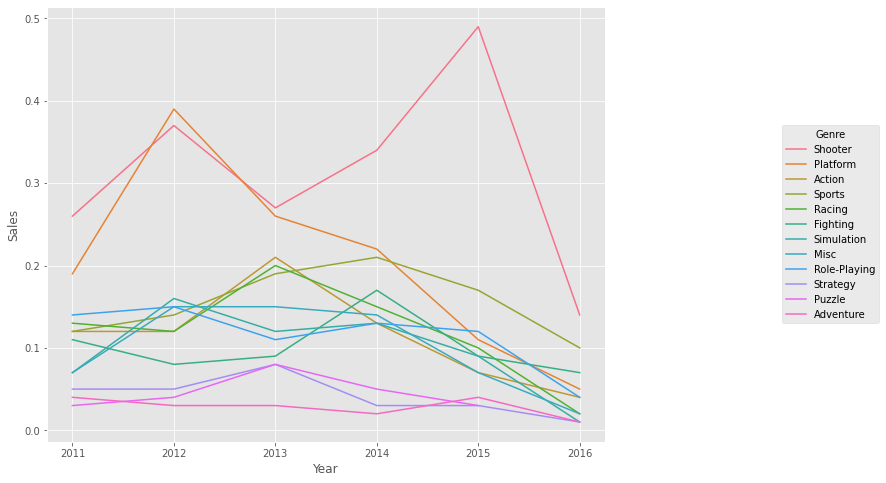

In [206]:
recent_10 = df[(df.Year>2010) & (df.Year<2017)][['Year', 'Genre', 'Sales']].groupby(['Year','Genre']).Sales.mean().round(2).sort_values(ascending=False).reset_index()
recent_10_ratio = pd.DataFrame({'Sales_ratio' : recent_10.groupby(['Year','Genre']).Sales.sum() / recent_10.groupby('Year').Sales.sum()}).reset_index()
plt.figure(figsize=(10,8))
g = sns.lineplot(data = recent_10, x = 'Year', y = 'Sales', hue = 'Genre', legend=True)
sns.move_legend(g, "center right", bbox_to_anchor=(1.5, 0.5))
plt.show()


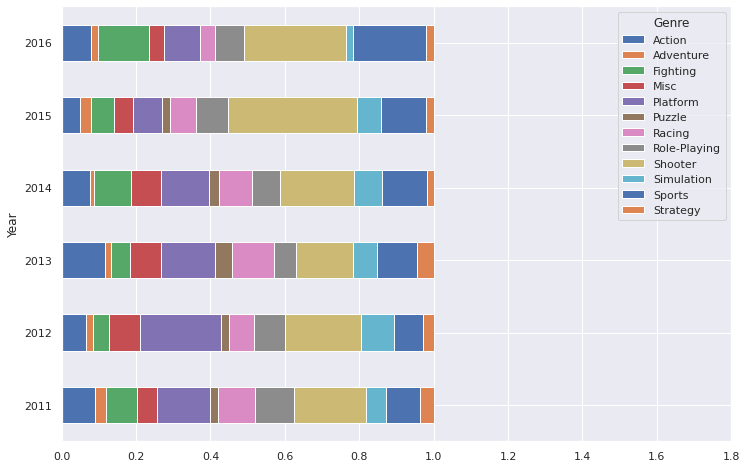

In [243]:
recent_10_pivot= recent_10_ratio.pivot(index = 'Year',columns='Genre', values = 'Sales_ratio').reset_index()

recent_10_pivot.plot(
    x = 'Year',
    kind = 'barh',
    stacked = True,
    mark_right = True, legend=True, figsize = (12,8))

plt.xlim([0,1.8])
plt.show()

2017년 현재에 가까워질수록 게임 산업계는 훨씬 더 빠르게 변동하고 있습니다.<br>
따라서 다음 분기에 설계할 게임을 찾기 위해서는 근 10년 데이터를 주로 보는 것이 알맞다고 생각됩니다.<br>
스포츠 장르는 꾸준한 증가를 보이고 있고, <br>
다른 분야는 액션, 격투, 플랫폼게임이 최근 증가를 보였으나 꾸준하진 않아 주의가 필요합니다.

따라서 스포츠 장르를 개발하는 것이 좋다고 생각합니다
